In [1]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%%bash
#fusermount -uz /mnt/work/dhuseljic
#sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [3]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def verify_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'

    result_json = path / 'results.json'
    if not result_json.is_file():
        raise ValueError()

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, verify_only=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    exp_paths = list(result_path.glob(glob_pattern))
    if len(exp_paths) < 1:
        raise ValueError(f'No experiments found in {result_path}')
    for exp_path in exp_paths:
        print('> Found', exp_path.name)
        if verify_only:
            verify_results(exp_path)
            continue
        d = load_results(exp_path)
        experiments.append(d)
    # assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/random/N_INIT{2048}__ACQ_SIZE{2048}__N_ACQ{9}/'
exp_results = get_experiments(Path(path), 'seed1', verify_only=True)
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
dict_keys(['test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['accuracy', 'nll', 'brier', 'tce', 'ace', 'oce'])


## Aleatoric Results

In [30]:
root_path = Path('/mnt/stud/work/ynagel/results/udal/')

verify_only = False
dataset = 'IMAGENET100'
model = 'resnet18'
experiments = {}
n_init = 2048
acq_size = 2048
num_cycles = 9
# Deterministic
experiments.update({
    'random eval':  root_path / f'active_learning/{dataset}/resnet18/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc eval':      root_path / f'active_learning/{dataset}/resnet18/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin eval':  root_path / f'active_learning/{dataset}/resnet18/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval': root_path / f'active_learning/{dataset}/resnet18/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

# # Labels smoothing
experiments.update({
    'random (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc (ls)':      root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (ls)': root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc (ls) eval':         root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (ls) eval':    root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# 
# Mixup
experiments.update({
    'random (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc (mixup)':       root_path / f'active_learning/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (mixup)':  root_path / f'active_learning/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'lc (mixup) eval':      root_path / f'evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (mixup) eval': root_path / f'evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=verify_only)

Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed1
> Found seed2
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/least_confident/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
> Found seed2
> Found seed3
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/margin/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed1
> Found seed2
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18/entropy/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
> Found seed2
> Found seed3
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_labelsmoothing/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed2
> Found seed1
> Found seed3
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_labelsmoothing/least_confident/N_INIT2048__ACQ_SIZE2048

100%|██████████| 20/20 [00:00<00:00, 139.76it/s]


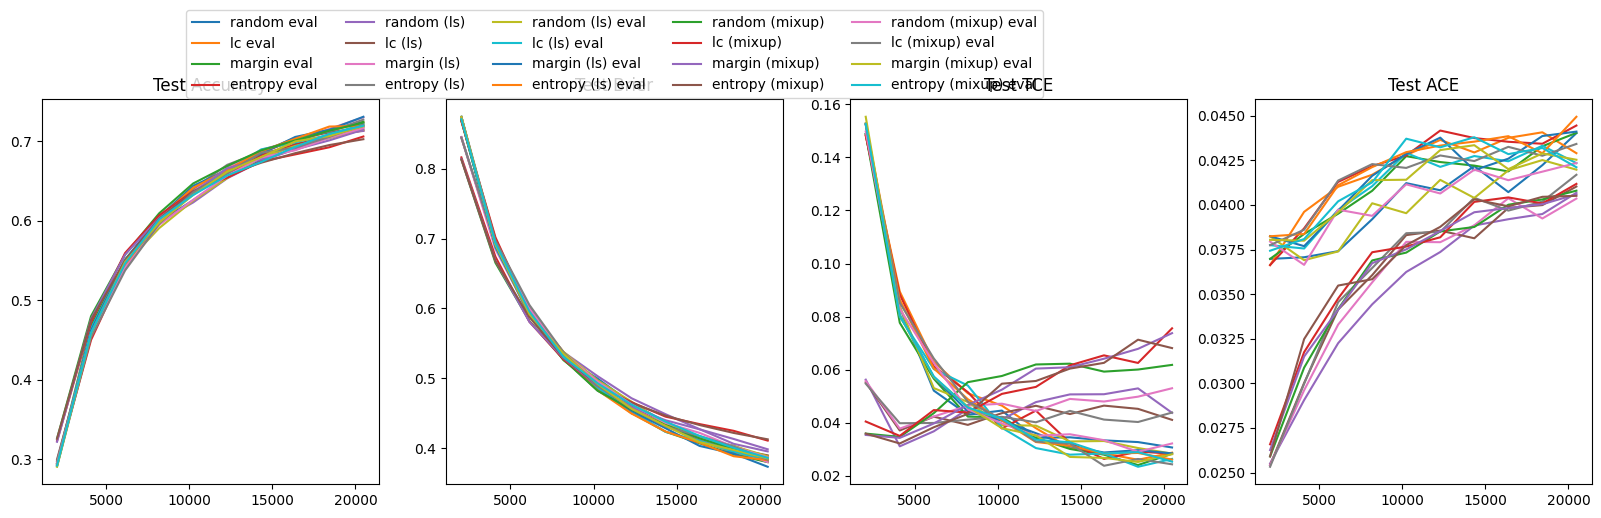

In [31]:
show_std = False
table_dict = {}
learning_curves = {}
plt.figure(figsize=(20, 5))
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)

    learning_curves[strat_name] = {
        'acc': test_accs_mean, 'acc_std': test_accs_std,
        'nll': test_nll_mean, 'nll_std': test_nll_std,
        'brier': test_brier_mean, 'brier_std': test_brier_std,
        'tce': test_tce_mean, 'tce_std': test_tce_std,
        'ace': test_ace_mean, 'ace_std': test_ace_std,
    }

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1],
        'ACE (AUC)': np.mean(test_ace_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)

    # plt.subplot(141)
    # plt.title('NLL')
    # plt.plot(test_accs_mean, test_nll_mean)
    # plt.subplot(142)
    # plt.title('Brier')
    # plt.plot(test_accs_mean, test_brier_mean)
    # plt.subplot(143)
    # plt.title('TCE')
    # plt.plot(test_accs_mean, test_tce_mean)
    # plt.subplot(144)
    # plt.title('ACE')
    # plt.plot(test_accs_mean, test_ace_mean)


plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [32]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict).T
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & nll (Final) & nll (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) \\
\midrule
random eval & 0.720 & 0.597 & 1.108 & 1.664 & 0.385 & 0.528 & 0.031 & 0.054 & 0.044 & 0.040 \\
lc eval & 0.723 & 0.600 & 1.036 & 1.606 & 0.380 & 0.527 & 0.029 & 0.055 & 0.043 & 0.042 \\
margin eval & 0.724 & 0.604 & 1.049 & 1.595 & 0.380 & 0.521 & 0.028 & 0.051 & 0.044 & 0.041 \\
entropy eval & 0.713 & 0.598 & 1.054 & 1.610 & 0.388 & 0.527 & 0.028 & 0.055 & 0.044 & 0.042 \\
random (ls) & 0.713 & 0.596 & 1.169 & 1.710 & 0.395 & 0.532 & 0.044 & 0.046 & 0.041 & 0.035 \\
lc (ls) & 0.717 & 0.601 & 1.075 & 1.629 & 0.390 & 0.525 & 0.041 & 0.044 & 0.041 & 0.036 \\
margin (ls) & 0.730 & 0.605 & 1.070 & 1.633 & 0.380 & 0.523 & 0.053 & 0.047 & 0.040 & 0.036 \\
entropy (ls) & 0.727 & 0.604 & 1.055 & 1.622 & 0.383 & 0.523 & 0.044 & 0.043 & 0.042 & 0.037 \\
random (ls) eval & 0.714 & 0.596 & 1.117 & 1.670 & 0.388 & 0.

In [33]:
df1 = df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']]
reindexer = ['random eval', 'random (ls)', 'random (mixup)', 'lc eval', 'lc (ls)', 'lc (mixup)', 'margin eval', 'margin (ls)', 'margin (mixup)', 'entropy eval', 'entropy (ls)', 'entropy (mixup)']
df1 = df1.reindex(index=reindexer)
pd.set_option('display.precision', 3)
display(df1)
print(df1.to_latex(float_format="%.3f"))

,nll (AUC),brier (AUC),TCE (AUC),ACE (AUC)
random eval,1.664,0.528,0.054,0.040
random (ls),1.710,0.532,0.046,0.035
random (mixup),1.619,0.516,0.053,0.036
lc eval,1.606,0.527,0.055,0.042
lc (ls),1.629,0.525,0.044,0.036
lc (mixup),1.587,0.527,0.053,0.037
margin eval,1.595,0.521,0.051,0.041
margin (ls),1.633,0.523,0.047,0.036
margin (mixup),1.585,0.522,0.054,0.036
entropy eval,1.610,0.527,0.055,0.042


\begin{tabular}{lrrrr}
\toprule
 & nll (AUC) & brier (AUC) & TCE (AUC) & ACE (AUC) \\
\midrule
random eval & 1.664 & 0.528 & 0.054 & 0.040 \\
random (ls) & 1.710 & 0.532 & 0.046 & 0.035 \\
random (mixup) & 1.619 & 0.516 & 0.053 & 0.036 \\
lc eval & 1.606 & 0.527 & 0.055 & 0.042 \\
lc (ls) & 1.629 & 0.525 & 0.044 & 0.036 \\
lc (mixup) & 1.587 & 0.527 & 0.053 & 0.037 \\
margin eval & 1.595 & 0.521 & 0.051 & 0.041 \\
margin (ls) & 1.633 & 0.523 & 0.047 & 0.036 \\
margin (mixup) & 1.585 & 0.522 & 0.054 & 0.036 \\
entropy eval & 1.610 & 0.527 & 0.055 & 0.042 \\
entropy (ls) & 1.622 & 0.523 & 0.043 & 0.037 \\
entropy (mixup) & 1.586 & 0.527 & 0.052 & 0.037 \\
\bottomrule
\end{tabular}



In [35]:
df2 = df[['acc (Final)', 'acc (AUC)']]
reindexer = ['random eval', 'random (ls) eval', 'random (mixup) eval', 'lc eval', 'lc (ls) eval', 'lc (mixup) eval', 'margin eval', 'margin (ls) eval', 'margin (mixup) eval', 'entropy eval', 'entropy (ls) eval', 'entropy (mixup) eval']
df2 = df2.reindex(index=reindexer)
display(df2)
print(df2.to_latex(float_format="%.3f"))

,acc (Final),acc (AUC)
random eval,0.720,0.597
random (ls) eval,0.714,0.596
random (mixup) eval,0.716,0.596
lc eval,0.723,0.600
lc (ls) eval,0.722,0.602
lc (mixup) eval,0.721,0.598
margin eval,0.724,0.604
margin (ls) eval,0.730,0.605
margin (mixup) eval,0.719,0.599
entropy eval,0.713,0.598


\begin{tabular}{lrr}
\toprule
 & acc (Final) & acc (AUC) \\
\midrule
random eval & 0.720 & 0.597 \\
random (ls) eval & 0.714 & 0.596 \\
random (mixup) eval & 0.716 & 0.596 \\
lc eval & 0.723 & 0.600 \\
lc (ls) eval & 0.722 & 0.602 \\
lc (mixup) eval & 0.721 & 0.598 \\
margin eval & 0.724 & 0.604 \\
margin (ls) eval & 0.730 & 0.605 \\
margin (mixup) eval & 0.719 & 0.599 \\
entropy eval & 0.713 & 0.598 \\
entropy (ls) eval & 0.719 & 0.603 \\
entropy (mixup) eval & 0.719 & 0.598 \\
\bottomrule
\end{tabular}



In [37]:
df3 = df[['nll (Final)', 'TCE (Final)', 'ACE (Final)']]
reindexer = ['random eval', 'random (ls) eval', 'random (mixup) eval', 'lc eval', 'lc (ls) eval', 'lc (mixup) eval', 'margin eval', 'margin (ls) eval', 'margin (mixup) eval', 'entropy eval', 'entropy (ls) eval', 'entropy (mixup) eval']
df3 = df3.reindex(index=reindexer)
print(df3.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & nll (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval & 1.11 & 0.03 & 0.04 \\
random (ls) eval & 1.12 & 0.03 & 0.04 \\
random (mixup) eval & 1.11 & 0.03 & 0.04 \\
lc eval & 1.04 & 0.03 & 0.04 \\
lc (ls) eval & 1.04 & 0.03 & 0.04 \\
lc (mixup) eval & 1.04 & 0.02 & 0.04 \\
margin eval & 1.05 & 0.03 & 0.04 \\
margin (ls) eval & 1.03 & 0.03 & 0.04 \\
margin (mixup) eval & 1.06 & 0.03 & 0.04 \\
entropy eval & 1.05 & 0.03 & 0.04 \\
entropy (ls) eval & 1.04 & 0.03 & 0.04 \\
entropy (mixup) eval & 1.06 & 0.03 & 0.04 \\
\bottomrule
\end{tabular}



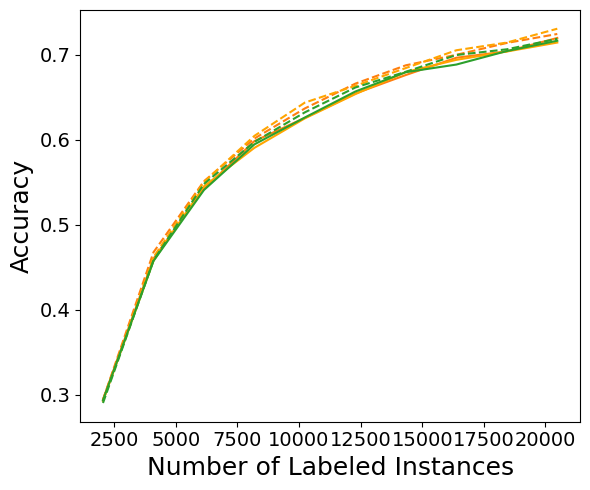

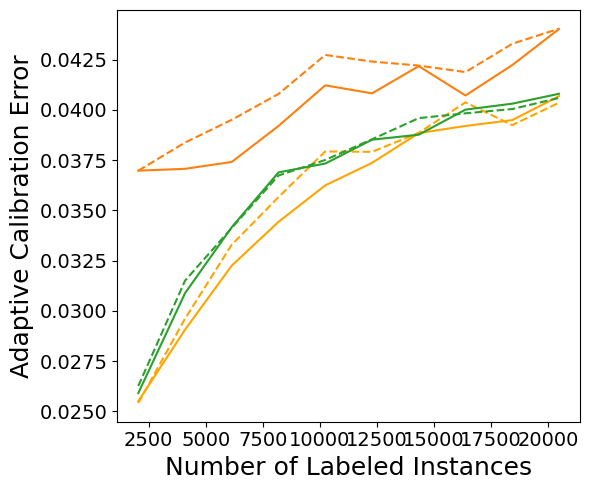

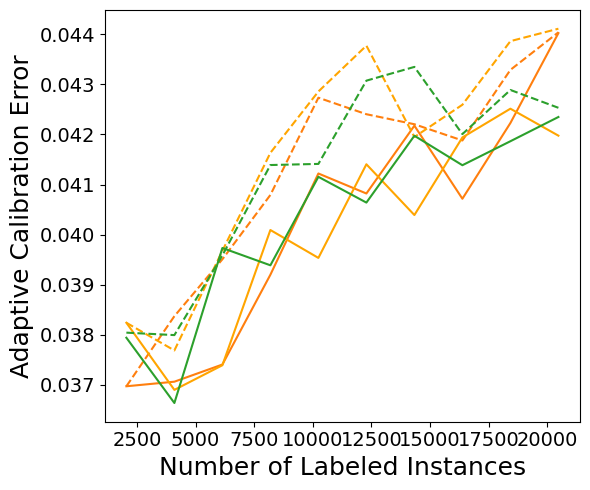

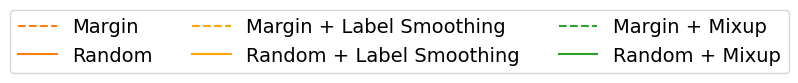

In [39]:
plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['acc'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['acc'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['acc'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['acc'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['acc'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['acc'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/evaluation_acc.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls)']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls)']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup)']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup)']['ace'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Adaptive Calibration Error', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/selection_ace.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['ace'], '--', color='C2', label='margin mixup')
plt.xticks(fontsize=14)
plt.xlabel('Number of Labeled Instances', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.ylabel('Adaptive Calibration Error', fontdict={'size': 18})
plt.tight_layout()
plt.savefig('plots_al/evaluation_ace.pdf', bbox_inches='tight', pad_inches=0) 

colors = {
    'margin': 'C1',
    'margin_ls': 'orange',
    'margin_mixup': 'C2',
}

fig = plt.figure()
plt.plot([], [], '--', label='Margin', color=colors['margin'])
plt.plot([], [], '-', label='Random', color=colors['margin'])
plt.plot([], [], '--', label='Margin + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '-', label='Random + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '--', label='Margin + Mixup', color=colors['margin_mixup'])
plt.plot([], [], '-', label='Random + Mixup', color=colors['margin_mixup'])
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=3,  prop=dict(size=14))
# cax = plt.axes([0.1, 1, .8, .02])
plt.tight_layout()
plt.savefig('plots_al/legend_exemplary_lc.pdf', bbox_inches='tight', pad_inches=0) 
plt.show()

## Epistemic Results

In [4]:
root_path = Path('/mnt/stud/work/ynagel/results/udal/')
dataset = 'IMAGENET100'
experiments = {}
n_init = 2048
acq_size = 2048
num_cycles = 9

# MC-Dropout
experiments.update({
    'random (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    #'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# Ensemble
experiments.update({
    'random (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    #'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    #'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# SNGP
experiments.update({
    'random (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    'random eval (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy eval (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald eval (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio eval (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=False)

Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_mcdropout/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed2
> Found seed1
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_mcdropout/bayesian_entropy/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed2
> Found seed1
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_mcdropout/bald/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed1
> Found seed2
> Found seed3
Searching in /mnt/stud/work/ynagel/results/udal/active_learning/IMAGENET100/resnet18_mcdropout/variation_ratio/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed3
> Found seed2
> Found seed1
Searching in /mnt/stud/work/ynagel/results/udal/evaluation/IMAGENET100/resnet18_mcdropout_sngp/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed2
> Found seed1
> Found seed3
Searching in /mnt/stud/work/ynagel/results/udal/evaluation/IMAGENET100/resnet18_mcdropout_sngp/bay

100%|██████████| 24/24 [00:00<00:00, 90.06it/s]


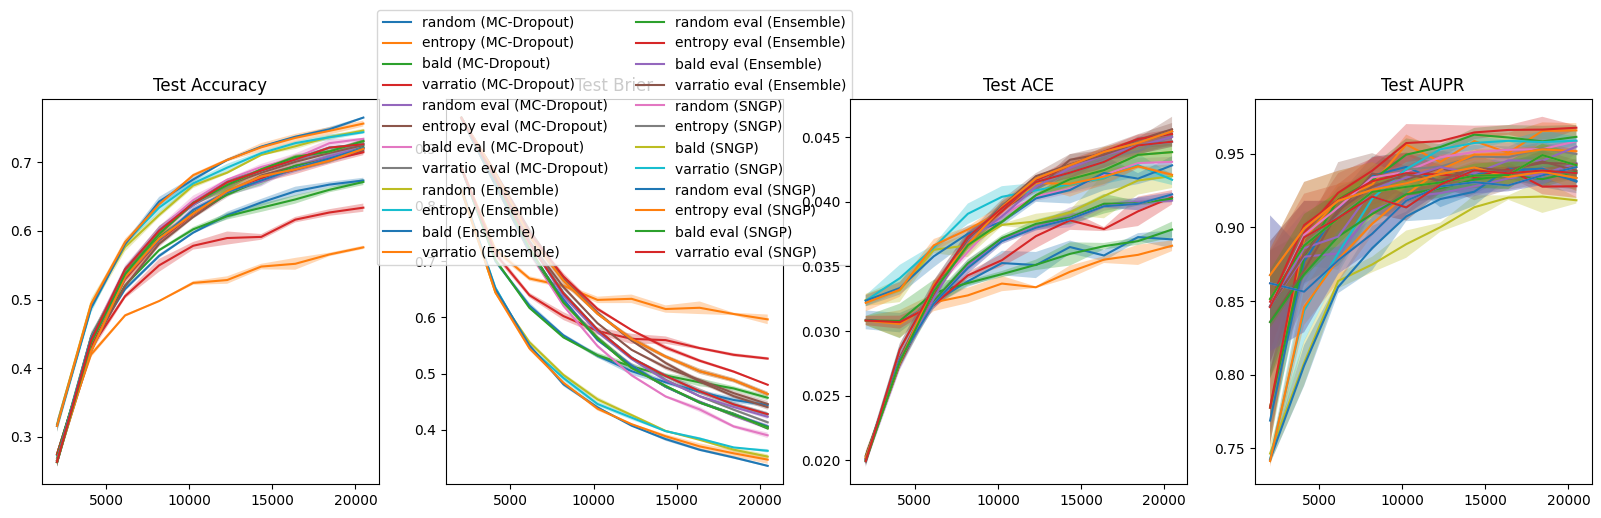

In [5]:
ood_datasets = ['CIFAR10', 'CIFAR100']
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    test_aupr_near = []
    test_aupr_far = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])
        test_aupr_near.append([data[cycle]['test_stats'].get(f'aupr_{ood_datasets[0]}', np.nan) for cycle in data])
        test_aupr_far.append([data[cycle]['test_stats'].get(f'aupr_{ood_datasets[1]}', np.nan) for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)
    test_aupr_far_mean, test_aupr_far_std = np.mean(test_aupr_far, 0), np.std(test_aupr_far, 0)
    test_aupr_near_mean, test_aupr_near_std = np.mean(test_aupr_near, 0), np.std(test_aupr_near, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1], 
        'ACE (AUC)': np.mean(test_ace_mean), 
        'AUPR near (Final)': test_aupr_near_mean[-1],
        'AUPR near (AUC)': np.mean(test_aupr_near_mean),
        'AUPR far (Final)': test_aupr_far_mean[-1],
        'AUPR far (AUC)': np.mean(test_aupr_far_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_far_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_far_mean-test_aupr_far_std, test_aupr_far_mean+test_aupr_far_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [6]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['acc (Final)', 'acc (AUC)', 'brier (Final)', 'brier (AUC)', 'ACE (Final)', 'ACE (AUC)', 'AUPR near (Final)', 'AUPR near (AUC)', 'AUPR far (Final)', 'AUPR far (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & brier (Final) & brier (AUC) & ACE (Final) & ACE (AUC) & AUPR near (Final) & AUPR near (AUC) & AUPR far (Final) & AUPR far (AUC) \\
\midrule
random (MC-Dropout) & 0.674 & 0.565 & 0.444 & 0.564 & 0.037 & 0.034 & 0.950 & 0.924 & 0.931 & 0.911 \\
entropy (MC-Dropout) & 0.576 & 0.496 & 0.597 & 0.661 & 0.037 & 0.034 & 0.967 & 0.930 & 0.966 & 0.926 \\
bald (MC-Dropout) & 0.671 & 0.564 & 0.457 & 0.571 & 0.038 & 0.035 & 0.967 & 0.931 & 0.961 & 0.926 \\
varratio (MC-Dropout) & 0.634 & 0.540 & 0.527 & 0.612 & 0.040 & 0.036 & 0.967 & 0.937 & 0.968 & 0.932 \\
random eval (MC-Dropout) & 0.722 & 0.591 & 0.403 & 0.597 & 0.040 & 0.035 & 0.942 & 0.912 & 0.944 & 0.911 \\
entropy eval (MC-Dropout) & 0.717 & 0.587 & 0.440 & 0.631 & 0.046 & 0.037 & 0.942 & 0.920 & 0.943 & 0.919 \\
bald eval (MC-Dropout) & 0.734 & 0.604 & 0.390 & 0.587 & 0.043 & 0.037 & 0.957 & 0.929 & 0.958 & 0.929 \\
varratio eval (MC-Dropout) & 0.728 & 0.598 & 0.413 & 0.60

In [7]:
# Create Table
pd.set_option('display.precision', 3)

df1 = df.T[['brier (AUC)', 'ACE (AUC)', 'AUPR near (AUC)', 'AUPR far (AUC)']]
reindexer = ['random (MC-Dropout)', 'random (SNGP)', 'random (Ensemble)', 
            'entropy (MC-Dropout)', 'entropy (SNGP)', 'entropy (Ensemble)', 
            'bald (MC-Dropout)', 'bald (SNGP)', 'bald (Ensemble)', 
            'varratio (MC-Dropout)', 'varratio (SNGP)', 'varratio (Ensemble)', ]
df1 = df1.reindex(index=reindexer)
display(df1)
print(df1.to_latex(float_format="%.3f"))

,brier (AUC),ACE (AUC),AUPR near (AUC),AUPR far (AUC)
random (MC-Dropout),0.564,0.034,0.924,0.911
random (SNGP),0.597,0.035,0.910,0.907
random (Ensemble),0.490,0.038,0.880,0.876
entropy (MC-Dropout),0.661,0.034,0.930,0.926
entropy (SNGP),0.638,0.038,0.924,0.922
entropy (Ensemble),0.490,0.039,0.917,0.911
bald (MC-Dropout),0.571,0.035,0.931,0.926
bald (SNGP),0.598,0.037,0.919,0.919
bald (Ensemble),0.479,0.039,0.890,0.885
varratio (MC-Dropout),0.612,0.036,0.937,0.932


\begin{tabular}{lrrrr}
\toprule
 & brier (AUC) & ACE (AUC) & AUPR near (AUC) & AUPR far (AUC) \\
\midrule
random (MC-Dropout) & 0.564 & 0.034 & 0.924 & 0.911 \\
random (SNGP) & 0.597 & 0.035 & 0.910 & 0.907 \\
random (Ensemble) & 0.490 & 0.038 & 0.880 & 0.876 \\
entropy (MC-Dropout) & 0.661 & 0.034 & 0.930 & 0.926 \\
entropy (SNGP) & 0.638 & 0.038 & 0.924 & 0.922 \\
entropy (Ensemble) & 0.490 & 0.039 & 0.917 & 0.911 \\
bald (MC-Dropout) & 0.571 & 0.035 & 0.931 & 0.926 \\
bald (SNGP) & 0.598 & 0.037 & 0.919 & 0.919 \\
bald (Ensemble) & 0.479 & 0.039 & 0.890 & 0.885 \\
varratio (MC-Dropout) & 0.612 & 0.036 & 0.937 & 0.932 \\
varratio (SNGP) & 0.612 & 0.037 & 0.914 & 0.916 \\
varratio (Ensemble) & 0.481 & 0.039 & 0.910 & 0.903 \\
\bottomrule
\end{tabular}



In [8]:
df2 = df.T[['acc (Final)', 'acc (AUC)']]
reindexer = ['random eval (MC-Dropout)', 'random eval (Ensemble)', 'random eval (SNGP)',
            'entropy eval (MC-Dropout)', 'entropy eval (Ensemble)', 'entropy eval (SNGP)',
            'bald eval (MC-Dropout)', 'bald eval (Ensemble)', 'bald eval (SNGP)',
            'varratio eval (MC-Dropout)', 'varratio eval (Ensemble)', 'varratio eval (SNGP)']
df2 = df2.reindex(index=reindexer)
display(df2)
print(df2.to_latex(float_format="%.3f"))

,acc (Final),acc (AUC)
random eval (MC-Dropout),0.722,0.591
random eval (Ensemble),0.722,0.592
random eval (SNGP),0.721,0.591
entropy eval (MC-Dropout),0.717,0.587
entropy eval (Ensemble),0.715,0.588
entropy eval (SNGP),0.720,0.589
bald eval (MC-Dropout),0.734,0.604
bald eval (Ensemble),0.732,0.598
bald eval (SNGP),0.731,0.598
varratio eval (MC-Dropout),0.728,0.598


\begin{tabular}{lrr}
\toprule
 & acc (Final) & acc (AUC) \\
\midrule
random eval (MC-Dropout) & 0.722 & 0.591 \\
random eval (Ensemble) & 0.722 & 0.592 \\
random eval (SNGP) & 0.721 & 0.591 \\
entropy eval (MC-Dropout) & 0.717 & 0.587 \\
entropy eval (Ensemble) & 0.715 & 0.588 \\
entropy eval (SNGP) & 0.720 & 0.589 \\
bald eval (MC-Dropout) & 0.734 & 0.604 \\
bald eval (Ensemble) & 0.732 & 0.598 \\
bald eval (SNGP) & 0.731 & 0.598 \\
varratio eval (MC-Dropout) & 0.728 & 0.598 \\
varratio eval (Ensemble) & 0.725 & 0.597 \\
varratio eval (SNGP) & 0.726 & 0.600 \\
\bottomrule
\end{tabular}



In [9]:
df3 = df.T[['AUPR near (Final)', 'AUPR far (Final)']]
reindexer = ['random eval (MC-Dropout)', 'random eval (Ensemble)', 'random eval (SNGP)',
            'entropy eval (MC-Dropout)', 'entropy eval (Ensemble)', 'entropy eval (SNGP)',
            'bald eval (MC-Dropout)', 'bald eval (Ensemble)', 'bald eval (SNGP)',
            'varratio eval (MC-Dropout)', 'varratio eval (Ensemble)', 'varratio eval (SNGP)']
df3 = df3.reindex(index=reindexer)
display(df3)
print(df3.to_latex(float_format="%.3f"))

,AUPR near (Final),AUPR far (Final)
random eval (MC-Dropout),0.942,0.944
random eval (Ensemble),0.935,0.938
random eval (SNGP),0.938,0.941
entropy eval (MC-Dropout),0.942,0.943
entropy eval (Ensemble),0.923,0.928
entropy eval (SNGP),0.935,0.934
bald eval (MC-Dropout),0.957,0.958
bald eval (Ensemble),0.956,0.955
bald eval (SNGP),0.940,0.942
varratio eval (MC-Dropout),0.950,0.950


\begin{tabular}{lrr}
\toprule
 & AUPR near (Final) & AUPR far (Final) \\
\midrule
random eval (MC-Dropout) & 0.942 & 0.944 \\
random eval (Ensemble) & 0.935 & 0.938 \\
random eval (SNGP) & 0.938 & 0.941 \\
entropy eval (MC-Dropout) & 0.942 & 0.943 \\
entropy eval (Ensemble) & 0.923 & 0.928 \\
entropy eval (SNGP) & 0.935 & 0.934 \\
bald eval (MC-Dropout) & 0.957 & 0.958 \\
bald eval (Ensemble) & 0.956 & 0.955 \\
bald eval (SNGP) & 0.940 & 0.942 \\
varratio eval (MC-Dropout) & 0.950 & 0.950 \\
varratio eval (Ensemble) & 0.942 & 0.939 \\
varratio eval (SNGP) & 0.932 & 0.937 \\
\bottomrule
\end{tabular}



In [10]:
df4 = df.T[['brier (Final)', 'TCE (Final)', 'ACE (Final)']]
reindexer = ['random eval (MC-Dropout)', 'random eval (Ensemble)', 'random eval (SNGP)',
            'entropy eval (MC-Dropout)', 'entropy eval (Ensemble)', 'entropy eval (SNGP)',
            'bald eval (MC-Dropout)', 'bald eval (Ensemble)', 'bald eval (SNGP)',
            'varratio eval (MC-Dropout)', 'varratio eval (Ensemble)', 'varratio eval (SNGP)']
df4 = df4.reindex(index=reindexer)
display(df4)
print(df4.to_latex(float_format="%.3f"))

,brier (Final),TCE (Final),ACE (Final)
random eval (MC-Dropout),0.403,0.137,0.040
random eval (Ensemble),0.402,0.135,0.040
random eval (SNGP),0.406,0.134,0.041
entropy eval (MC-Dropout),0.440,0.195,0.046
entropy eval (Ensemble),0.480,0.254,0.045
entropy eval (SNGP),0.464,0.237,0.045
bald eval (MC-Dropout),0.390,0.145,0.043
bald eval (Ensemble),0.423,0.194,0.045
bald eval (SNGP),0.405,0.166,0.044
varratio eval (MC-Dropout),0.413,0.175,0.045


\begin{tabular}{lrrr}
\toprule
 & brier (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval (MC-Dropout) & 0.403 & 0.137 & 0.040 \\
random eval (Ensemble) & 0.402 & 0.135 & 0.040 \\
random eval (SNGP) & 0.406 & 0.134 & 0.041 \\
entropy eval (MC-Dropout) & 0.440 & 0.195 & 0.046 \\
entropy eval (Ensemble) & 0.480 & 0.254 & 0.045 \\
entropy eval (SNGP) & 0.464 & 0.237 & 0.045 \\
bald eval (MC-Dropout) & 0.390 & 0.145 & 0.043 \\
bald eval (Ensemble) & 0.423 & 0.194 & 0.045 \\
bald eval (SNGP) & 0.405 & 0.166 & 0.044 \\
varratio eval (MC-Dropout) & 0.413 & 0.175 & 0.045 \\
varratio eval (Ensemble) & 0.446 & 0.221 & 0.045 \\
varratio eval (SNGP) & 0.428 & 0.194 & 0.045 \\
\bottomrule
\end{tabular}



## Load Experiment

In [ ]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

model_name = 'resnet18_mcdropout'
strat_name = 'random'
exp_path = Path(f'results/active_learning/CIFAR10/{model_name}/{strat_name}/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/seed1')
checkpoint = torch.load(exp_path / 'checkpoint.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, n_classes=10)
model = trainer.model
model.load_state_dict(checkpoint['model'])

args.dataset_path = '/datasets'
_, _, test_ds, _ = build_datasets(args)

2023-05-02 22:12:41.242831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:12:41.894472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
results = load_json(exp_path / 'results.json')
results['cycle19']['test_stats']

{'test_acc1': 72.94999694824219,
 'test_loss': 0.9619036912918091,
 'test_nll': 0.8499259948730469,
 'test_brier': 0.38014087080955505,
 'test_tce': 0.06486481428146362,
 'test_mce': 0.036187052726745605,
 'test_CIFAR100_auroc': 0.7402122050000001,
 'test_CIFAR100_aupr': 0.6967468314841072,
 'test_SVHN_auroc': 0.7186415776736323,
 'test_SVHN_aupr': 0.8092618874912202}

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

AttributeError: 'DropoutResNet18' object has no attribute 'forward_sample'

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
probas = model.get_probas(test_loader, device='cuda').mean(1)
logits = probas.log()

In [ ]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from torchmetrics.classification import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(n_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

ValueError: The `preds` and `target` should have the same first dimension.

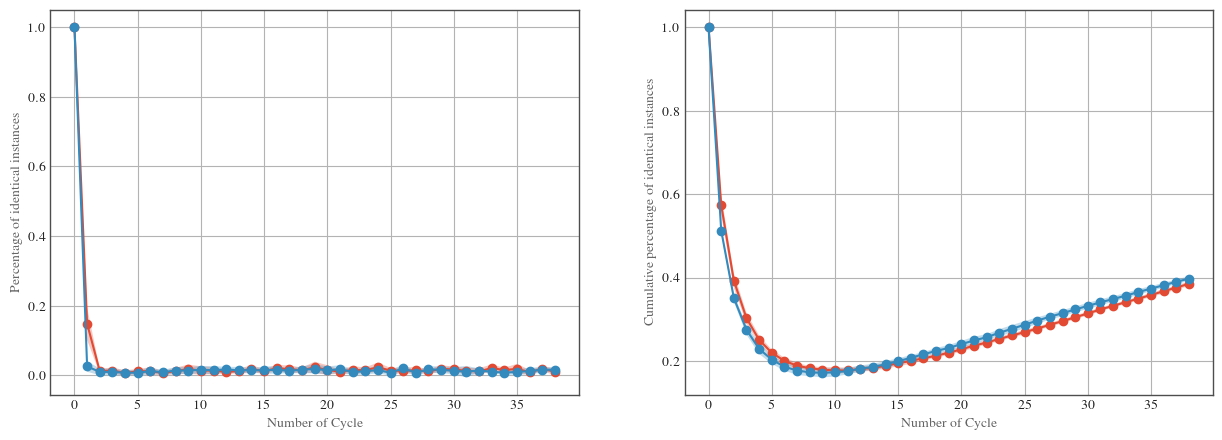

In [71]:
plt.figure(figsize=(15, 5))

for method in ['ls', 'mixup']:

    buy_agreement_list = []
    cum_buy_agreement_list = []

    for i_seed in range(1, 11):
        dir1 = experiments['entropy eval']
        json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices1 = load_json(json1)

        dir2 = experiments[f'entropy ({method})']
        json2 = dir2 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices2 = load_json(json2)

        indices1 = []
        indices2 = []

        buy_agreement = []
        cumulative_buy_agreement = []

        for key in queried_indices1:
            q_indices1 = queried_indices1[key]
            q_indices2 = queried_indices2[key]
            indices1.extend(q_indices1)
            indices2.extend(q_indices2)

            buy_agreement.append(np.isin(q_indices1, q_indices2).mean())
            cumulative_buy_agreement.append((np.isin(indices1, indices2).mean()))

        buy_agreement_list.append(buy_agreement)
        cum_buy_agreement_list.append(cumulative_buy_agreement)

    buy_agreement_mean = np.mean(buy_agreement_list, axis=0)
    buy_agreement_std = np.std(buy_agreement_list, axis=0)
    cum_buy_agreement_mean = np.mean(cum_buy_agreement_list, axis=0)
    cum_buy_agreement_std = np.std(cum_buy_agreement_list, axis=0)

    plt.subplot(121)
    plt.plot(buy_agreement_mean, '-o')
    plt.fill_between(range(len(buy_agreement_mean)), buy_agreement_mean+buy_agreement_std, buy_agreement_mean-buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Percentage of identical instances')

    plt.subplot(122)
    plt.plot(cum_buy_agreement_mean, '-o')

    plt.fill_between(range(len(cum_buy_agreement_mean)), cum_buy_agreement_mean+cum_buy_agreement_std, cum_buy_agreement_mean-cum_buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Cumulative percentage of identical instances')

plt.show()

In [60]:
buy_agreement_list[0]
buy_agreement_list[1]

[1.0,
 0.03125,
 0.0,
 0.015625,
 0.0,
 0.0234375,
 0.0,
 0.0078125,
 0.015625,
 0.0,
 0.0234375,
 0.0390625,
 0.015625,
 0.0234375,
 0.015625,
 0.0390625,
 0.0234375,
 0.0078125,
 0.03125,
 0.03125,
 0.0390625,
 0.015625,
 0.015625,
 0.015625,
 0.0078125,
 0.0,
 0.0078125,
 0.015625,
 0.015625,
 0.0234375,
 0.015625,
 0.0234375,
 0.0234375,
 0.015625,
 0.0,
 0.015625,
 0.015625,
 0.015625,
 0.015625]

10


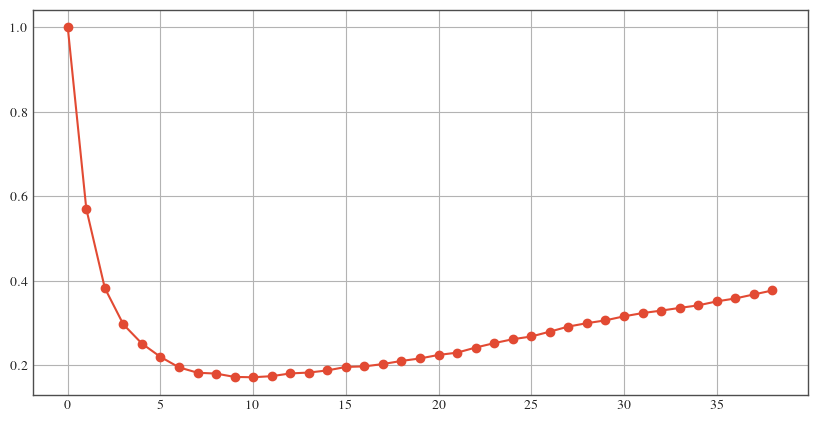

In [97]:
print(i_seed)
dir1 = experiments['entropy eval']
json1 = dir1 / f'seed{i_seed}' / 'results.json'
results1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(results1[key]['labeled_indices'], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')

10


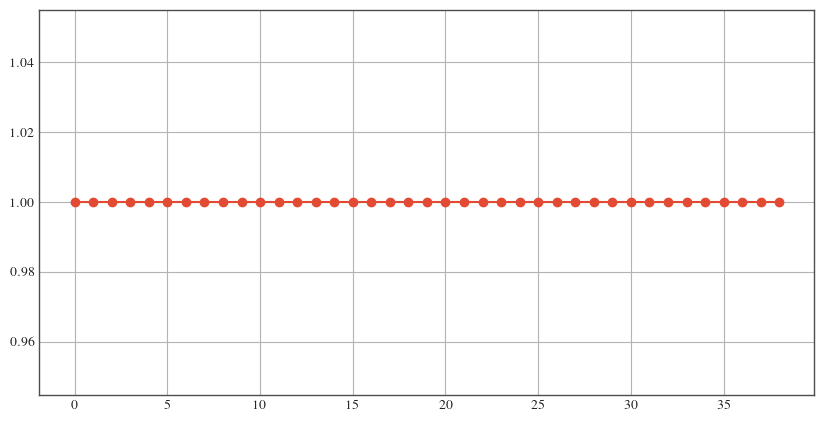

In [98]:
print(i_seed)
dir1 = experiments['entropy (ls)']
json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
queried_indices1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(queried_indices1[key], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')